# Time Series forecasting with Prophet

This code follows directly the examples from [this article](https://towardsdatascience.com/time-series-forecasting-with-lstms-and-prophet-predict-your-email-workload-48bf9cdb1580) by [Maximilian Strauss](https://towardsdatascience.com/@straussmaximilian) on Medium. 

Note: I wasn't able to connect to Gmail simply through the steps provided by Maximilian, so I had to enable 2-factor authentication in Gmail and create a secure password. [Sign in using App Passwords](https://support.google.com/mail/answer/185833?hl=en)

**Goal**: predict the number of emails that I will receive in my Inbox in the next 14 days. 

In [18]:
import imapclient
import pandas as pd
import getpass
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Connect to IMAP and get email data

First we connect to Gmail and get data on emails since a specified date. 

In [ ]:
youremail = input()
yourpassword = getpass.getpass()

In [14]:
imapObj = imapclient.IMAPClient("imap.gmail.com", ssl=False)
imapObj.login(youremail, yourpassword)
imapObj.select_folder("Inbox", readonly=True)

UIDs = imapObj.search('(SINCE "01-Jan-2016")')

mails = []
for msgid, data in imapObj.fetch(UIDs, ["ENVELOPE"]).items():
    envelope = data[b"ENVELOPE"]
    date = envelope.date
    if envelope.subject is not None:
        subject = envelope.subject.decode()
    else:
        subject = None
    mails.append((subject, date))

mail_df = pd.DataFrame(mails)
mail_df.columns = ["Subject", "Date"]
mail_df["Date"] = pd.to_datetime(mail_df["Date"])
mail_df = mail_df.set_index("Date")

print("A total of {} e-mails loaded.".format(len(mail_df)))

A total of 2658 e-mails loaded.


In [16]:
mail_df.tail()

,Subject
Date,
2019-06-12 21:25:20,"Tuesday: Join 20 Berlin PyLadies at ""PyConDE &..."
2019-06-12 22:21:32,Critical security alert
2019-06-12 22:26:09,2-Step Verification turned on
2019-06-12 22:27:26,App password created
2019-06-12 22:30:06,Berlin's fastest and most exciting startups hi...


## Visualize the data

In this step we want to understand how the email volume is distributed over time, specifically:
- Through the day
- Over a week

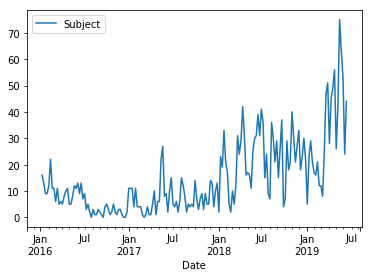

In [33]:
per_week = pd.DataFrame(mail_df["Subject"].resample("w").count())
per_week.plot(kind = 'line')
plt.show()

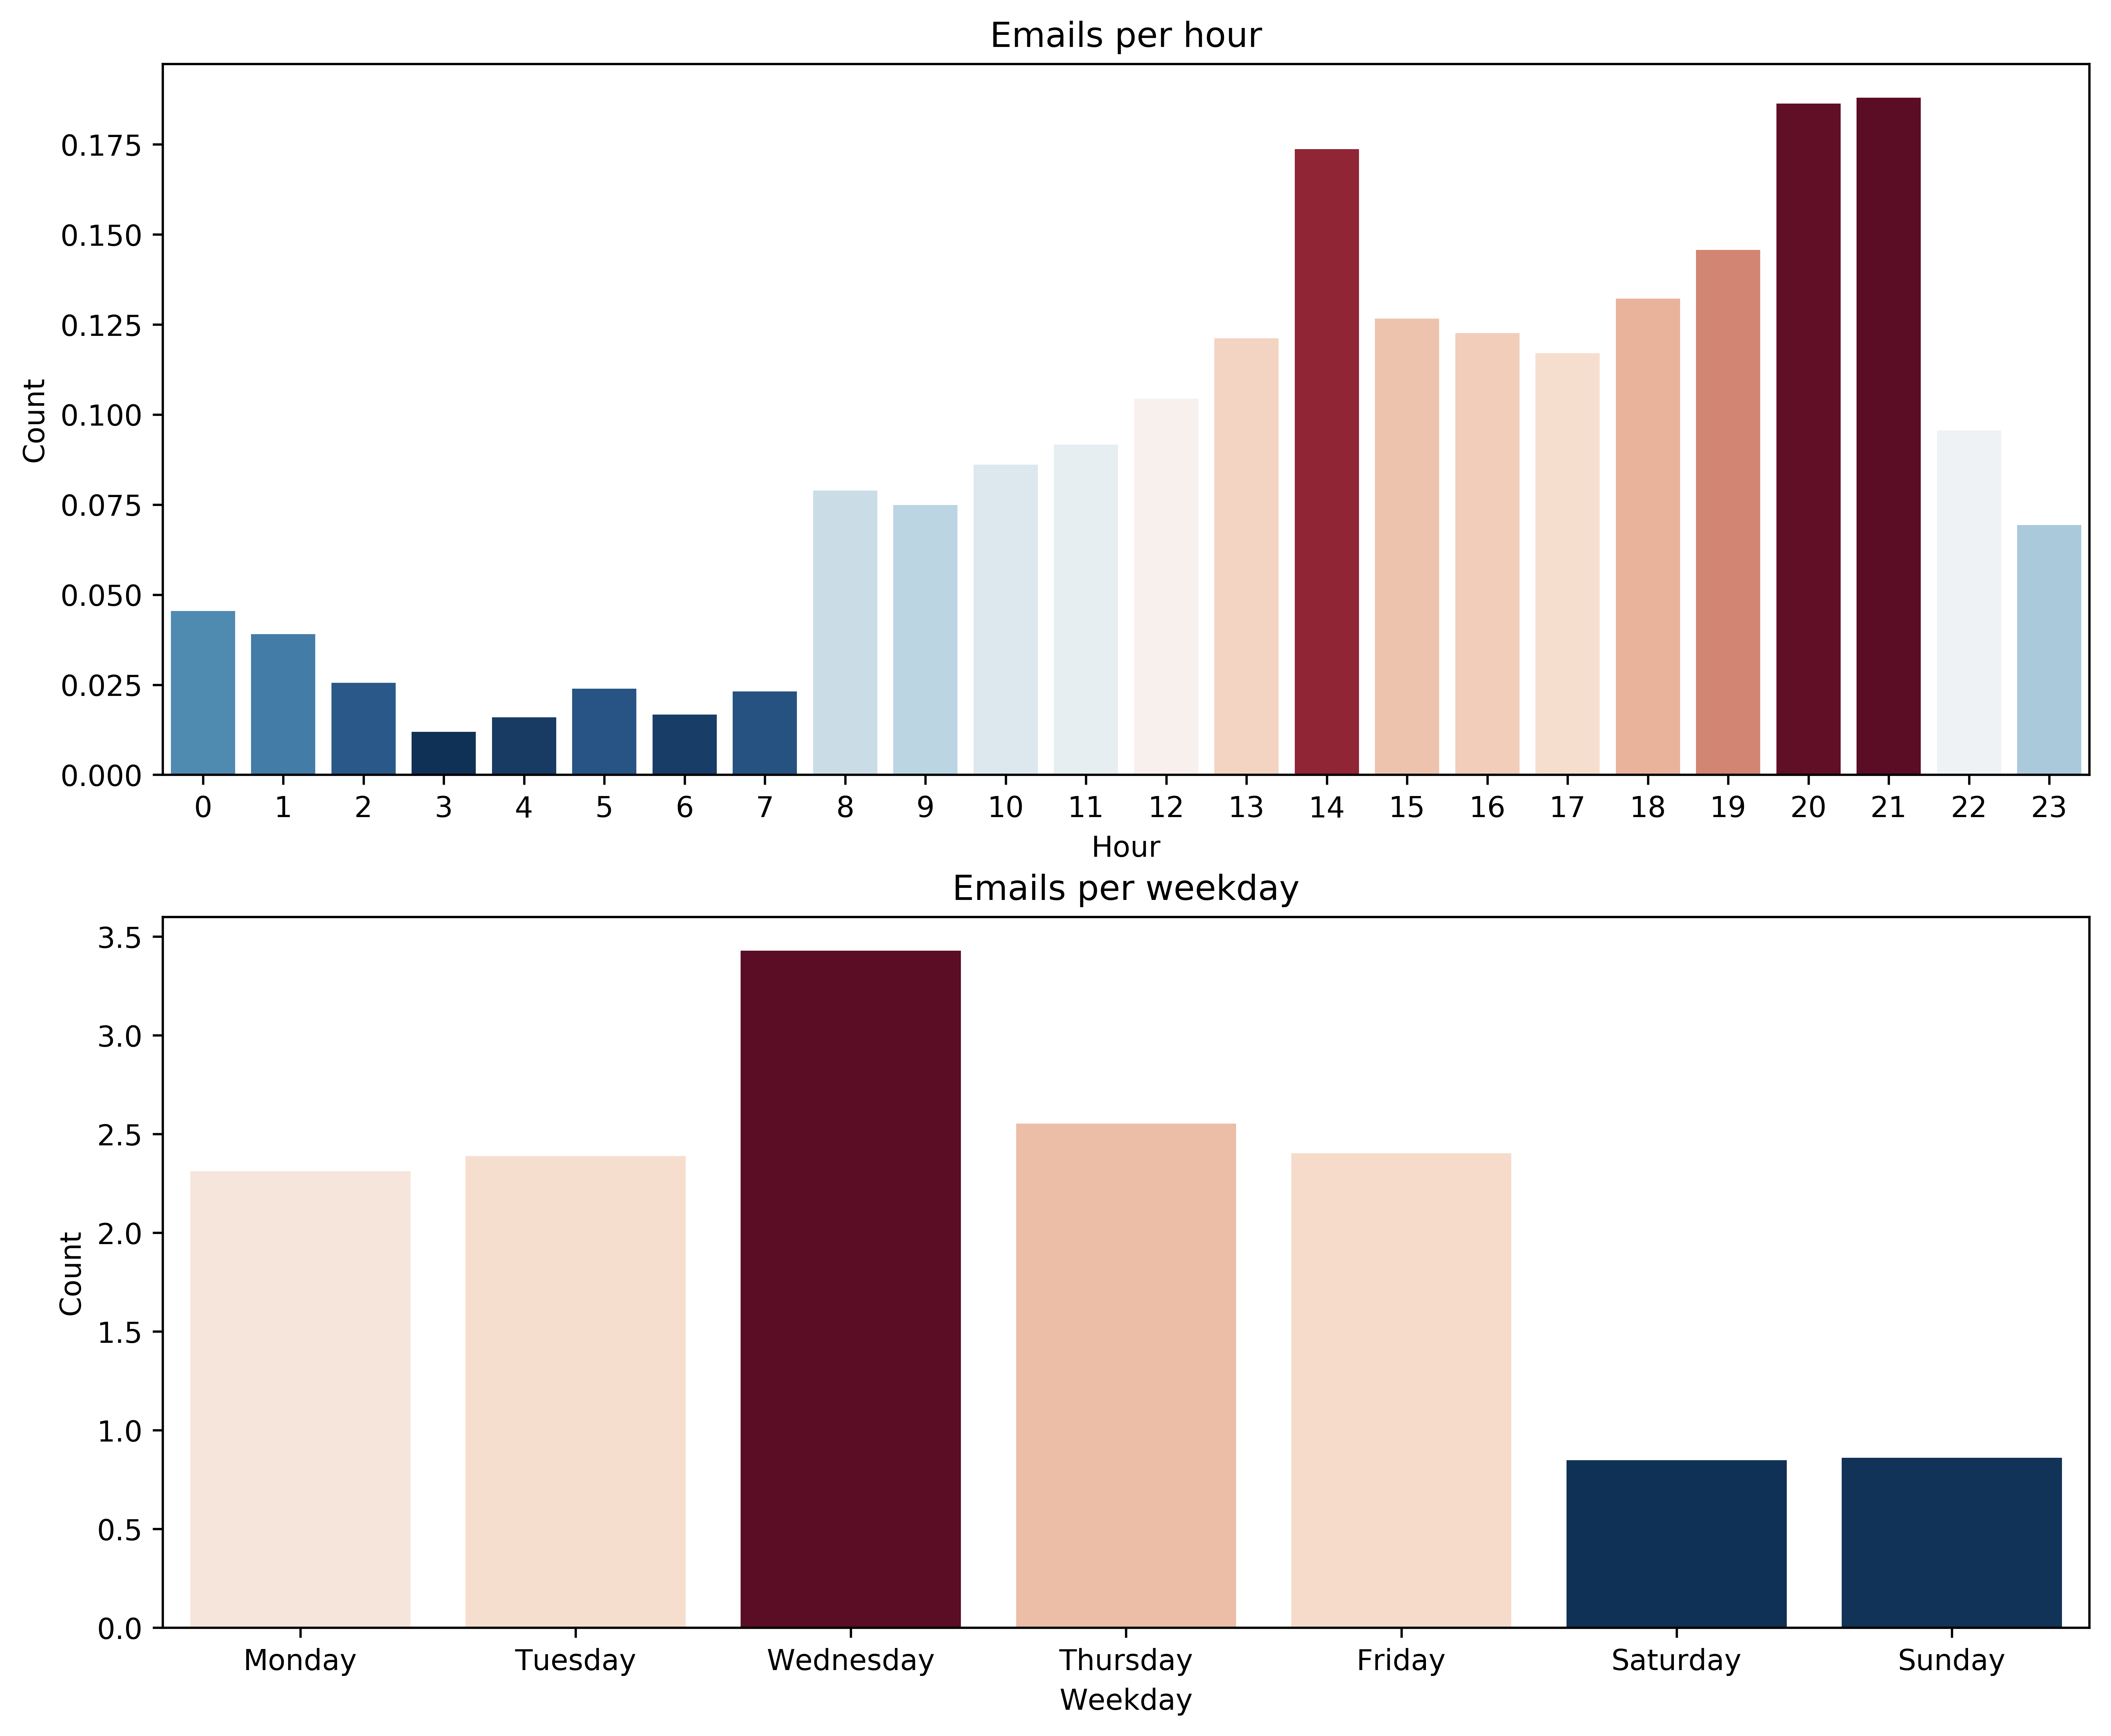

Average number of emails per day: 2.12


In [19]:
weekdays = [calendar.day_name[i] for i in range(7)]

# E-Mails per Hour
per_hour = pd.DataFrame(mail_df["Subject"].resample("h").count())
per_hour_day = (
    per_hour.groupby([per_hour.index.hour]).sum()
    / per_hour.groupby([per_hour.index.hour]).count()
)
per_hour_day.reset_index(inplace=True)
per_hour_day.columns = ["Hour", "Count"]

# E-Mails per day
per_day = pd.DataFrame(mail_df["Subject"].resample("d").count())
per_day_week = (
    per_day.groupby([per_day.index.weekday]).sum()
    / per_day.groupby([per_day.index.weekday]).count()
)
per_day_week.reset_index(inplace=True)
per_day_week.columns = ["Weekday", "Count"]
per_day_week["Weekday"] = weekdays

def return_cmap(data):
    # Function to create a colormap
    v = data["Count"].values
    colors = plt.cm.RdBu_r((v - v.min()) / (v.max() - v.min()))
    return colors

plt.figure(figsize=(12, 10), dpi=600)
plt.subplot(2, 1, 1)
cmap = return_cmap(per_hour_day)
sns.barplot(x="Hour", y="Count", data=per_hour_day, palette=cmap)
plt.title("Emails per hour")

plt.subplot(2, 1, 2)
cmap = return_cmap(per_day_week)
sns.barplot(x="Weekday", y="Count", data=per_day_week, palette=cmap)
plt.title("Emails per weekday")

plt.show()

print("Average number of emails per day: {:.2f}".format(per_hour_day.sum()["Count"]))

## Create baseline model to compare to (basically just seasonality)

In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np

data = per_day.copy()
test_split = int(len(data) * 0.8)

pred_base = []
for i in range(len(data) - test_split):
    train_data = data[i : test_split + i]
    test_data = data.iloc[test_split + i]
    train_data_week = (
        train_data.groupby([train_data.index.weekday]).sum()
        / train_data.groupby([train_data.index.weekday]).count()
    )
    baseline_prediction = train_data_week.loc[test_data.name.weekday()]
    pred_base.append(baseline_prediction.values)

test_data = data[test_split:]

# Calculate Mean Squared Error
mse_baseline = mean_squared_error(test_data.values, pred_base)

print("RMSE for BASELINE {:.2f}".format(np.sqrt(mse_baseline)))

RMSE for BASELINE 4.70


## Predict next 28 days using Prophet

Unlike the original notebook, I had to add the argument `daily_seasonality` = True when instantiating the `Prophet`object and predicting for 28 periods. 

In [37]:
from fbprophet import Prophet
from tqdm import tqdm

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [69]:
prophet_data = data.reset_index()
prophet_data["ds"] = prophet_data["Date"]
prophet_data["y"] = prophet_data["Subject"]

pred = []
for i in tqdm(range(len(data) - test_split)):

    data_to_fit = prophet_data[: (test_split + i)]
    prophet_model = Prophet(interval_width=0.95, daily_seasonality=True)

    prophet_model.fit(data_to_fit)

    prophet_forecast = prophet_model.make_future_dataframe(periods=28, freq="d") # predict 28 days
    prophet_forecast = prophet_model.predict(prophet_forecast)

    pred.append(prophet_forecast["yhat"].iloc[-1])

# Again, calculate the Mean Squared Error
mse_prophet = mean_squared_error(test_data.values, pred)

print("RMSE for PROPHET {:.2f}".format(np.sqrt(mse_prophet)))


  0%|          | 0/252 [00:00<?, ?it/s]/Users/tania/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):

 60%|█████▉    | 150/252 [12:40<08:29,  5.00s/it]


100%|██████████| 252/252 [20:34<00:00,  4.73s/it]


RMSE for PROPHET 4.02


### Plot seasonality trends

In `prophet`, those are called "components"

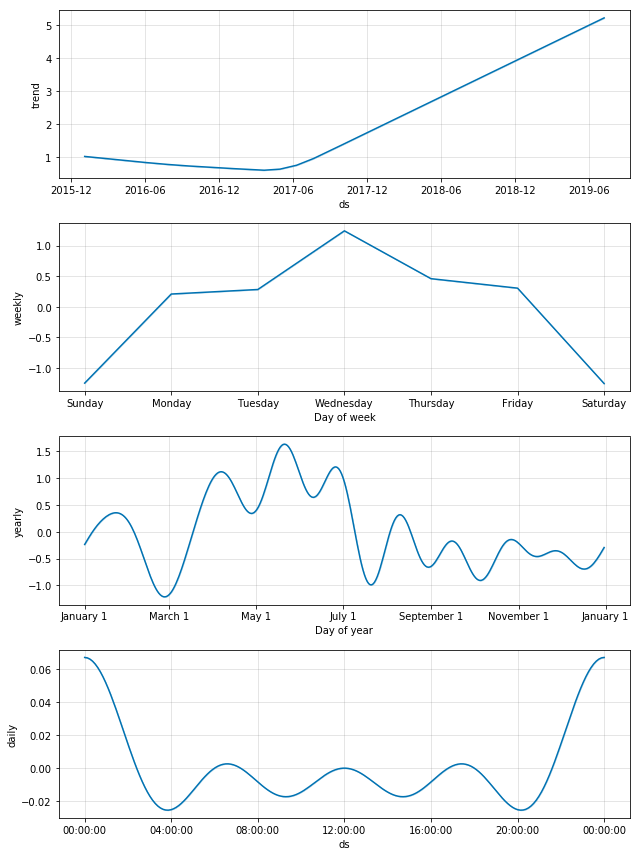

In [74]:
from fbprophet.diagnostics import performance_metrics
prophet_model.plot_components(prophet_forecast);  #have to add ; to avoid rendering the plots twice

### Plot the model forecast 

For the next 28 days (remember the daily seasonality in the `Prophet` object)

In [71]:
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-04,1.015918,-3.075869,5.292939,1.015918,1.015918,0.140073,0.140073,0.140073,0.067084,...,0.208951,0.208951,0.208951,-0.135962,-0.135962,-0.135962,0.0,0.0,0.0,1.155991
1,2016-01-05,1.014676,-2.970350,5.440377,1.014676,1.014676,0.257259,0.257259,0.257259,0.067084,...,0.282762,0.282762,0.282762,-0.092587,-0.092587,-0.092587,0.0,0.0,0.0,1.271934
2,2016-01-06,1.013433,-1.949630,6.486964,1.013433,1.013433,1.256109,1.256109,1.256109,0.067084,...,1.239574,1.239574,1.239574,-0.050549,-0.050549,-0.050549,0.0,0.0,0.0,2.269542
3,2016-01-07,1.012190,-2.739118,5.732238,1.012190,1.012190,0.516457,0.516457,0.516457,0.067084,...,0.459440,0.459440,0.459440,-0.010067,-0.010067,-0.010067,0.0,0.0,0.0,1.528647
4,2016-01-08,1.010947,-2.992018,5.612691,1.010947,1.010947,0.400633,0.400633,0.400633,0.067084,...,0.304864,0.304864,0.304864,0.028686,0.028686,0.028686,0.0,0.0,0.0,1.411581


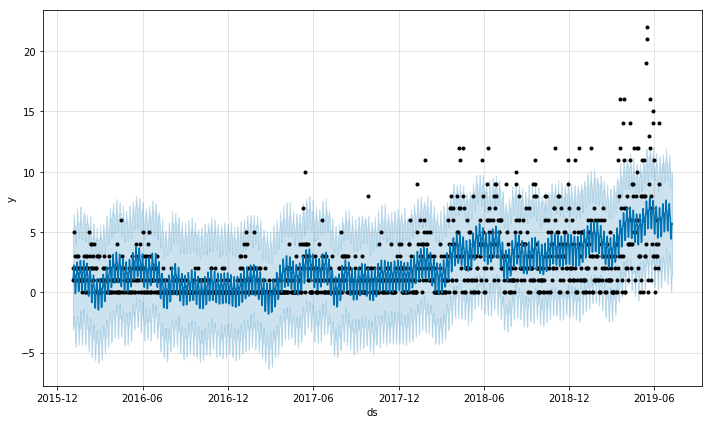

In [73]:
prophet_model.plot(prophet_forecast, uncertainty=True);

In [67]:
from datetime import datetime, timedelta

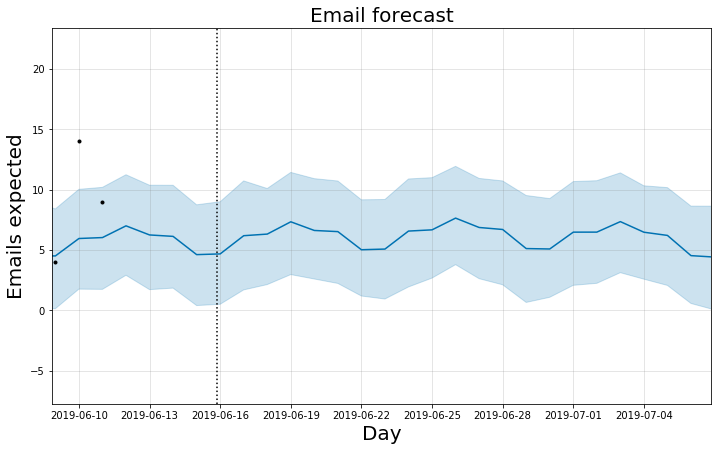

In [85]:
fig1 = prophet_model.plot(prophet_forecast)

datenow = datetime.now()
dateend = datenow + timedelta(days=21)
datestart = dateend - timedelta(days=28)

plt.xlim([datestart, dateend])
plt.title("Email forecast", fontsize=20)
plt.xlabel("Day", fontsize=20)
plt.ylabel("Emails expected", fontsize=20)
plt.axvline(datenow, color="k", linestyle=":")
plt.show()